In [2]:
import pandas as pd

covid_data_path = 'data/covid_worldwide.csv'
population_data_path = 'data/world_population.csv'
vaccination_data_path = 'data/country_vaccinations.csv'

covid_data = pd.read_csv(covid_data_path)
population_data = pd.read_csv(population_data_path)
vaccination_data = pd.read_csv(vaccination_data_path)

covid_data.head(), population_data.head(), vaccination_data.head()

(   Serial Number  Country  Total Cases Total Deaths Total Recovered  \
 0              1      USA  104,196,861    1,132,935     101,322,779   
 1              2    India   44,682,784      530,740      44,150,289   
 2              3   France   39,524,311      164,233      39,264,546   
 3              4  Germany   37,779,833      165,711      37,398,100   
 4              5   Brazil   36,824,580      697,074      35,919,372   
 
   Active Cases     Total Test     Population  
 0    1,741,147  1,159,832,679    334,805,269  
 1        1,755    915,265,788  1,406,631,776  
 2       95,532    271,490,188     65,584,518  
 3      216,022    122,332,384     83,883,596  
 4      208,134     63,776,166    215,353,593  ,
    Rank CCA3 Country/Territory           Capital Continent  2022 Population  \
 0    36  AFG       Afghanistan             Kabul      Asia         41128771   
 1   138  ALB           Albania            Tirana    Europe          2842321   
 2    34  DZA           Algeria      

In [3]:
# Clean and preprocess the COVID-19 data
# Convert columns to numeric, removing commas and non-numeric characters
covid_columns_to_numeric = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases', 'Total Test', 'Population']
for col in covid_columns_to_numeric:
    covid_data[col] = pd.to_numeric(covid_data[col].str.replace(',', '').str.strip(), errors='coerce')

# Clean and preprocess the vaccination data
vaccination_data['date'] = pd.to_datetime(vaccination_data['date'])  # Ensure date is in datetime format

# Aggregation for vaccination data
aggregated_vaccination_data = vaccination_data.groupby('country').agg({
    'total_vaccinations': 'max',
    'people_vaccinated': 'max',
    'people_fully_vaccinated': 'max',
    'daily_vaccinations_raw': 'sum',
    'daily_vaccinations': 'sum',
    'total_vaccinations_per_hundred': 'max',
    'people_vaccinated_per_hundred': 'max',
    'people_fully_vaccinated_per_hundred': 'max',
    'daily_vaccinations_per_million': 'mean',
}).reset_index()

# Merge datasets: covid_data, population_data, and aggregated_vaccination_data
merged_data = covid_data.merge(population_data[['Country/Territory', '2022 Population']],
                               left_on='Country',
                               right_on='Country/Territory',
                               how='inner')

merged_data = merged_data.merge(aggregated_vaccination_data,
                                left_on='Country',
                                right_on='country',
                                how='inner')

# Drop redundant columns
merged_data = merged_data.drop(columns=['Country/Territory', 'country'])

# Display the cleaned and merged data
merged_data.to_csv('data/merged_covid.csv', index=False)

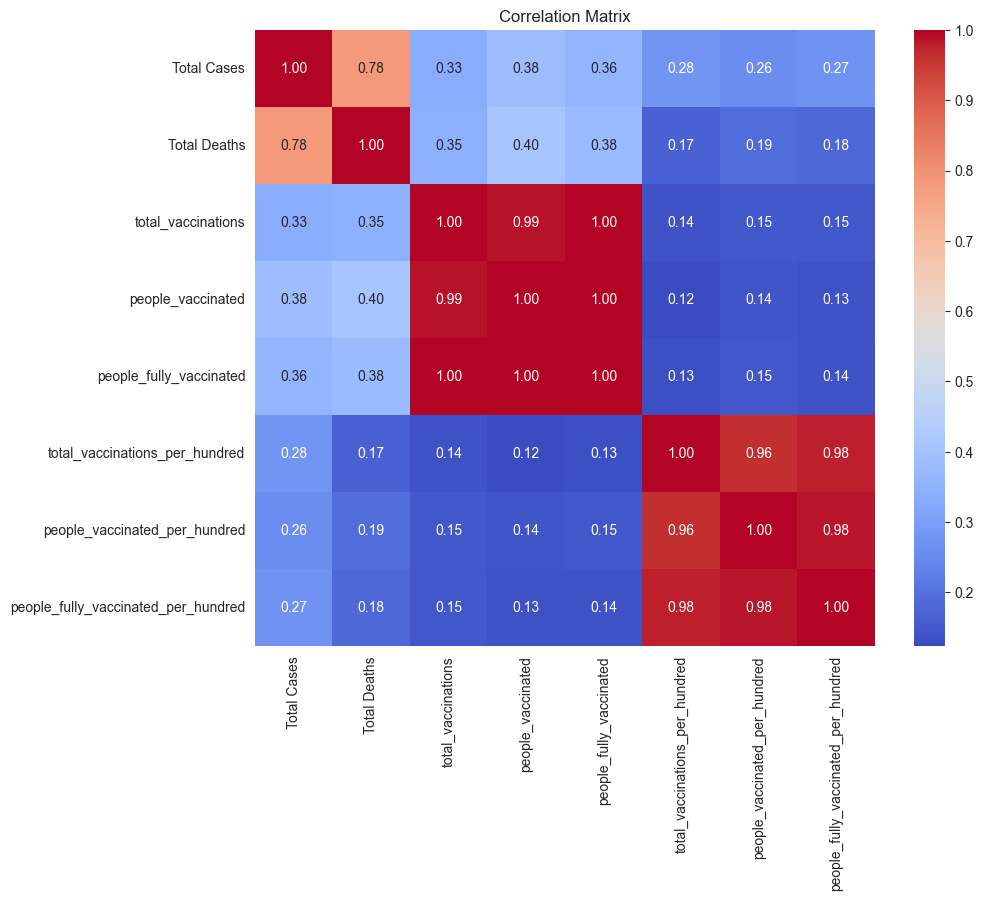

In [4]:
correlation_columns = [
    'Total Cases', 'Total Deaths', 'total_vaccinations',
    'people_vaccinated', 'people_fully_vaccinated',
    'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred'
]

# Compute the correlation matrix
correlation_matrix = merged_data[correlation_columns].corr()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

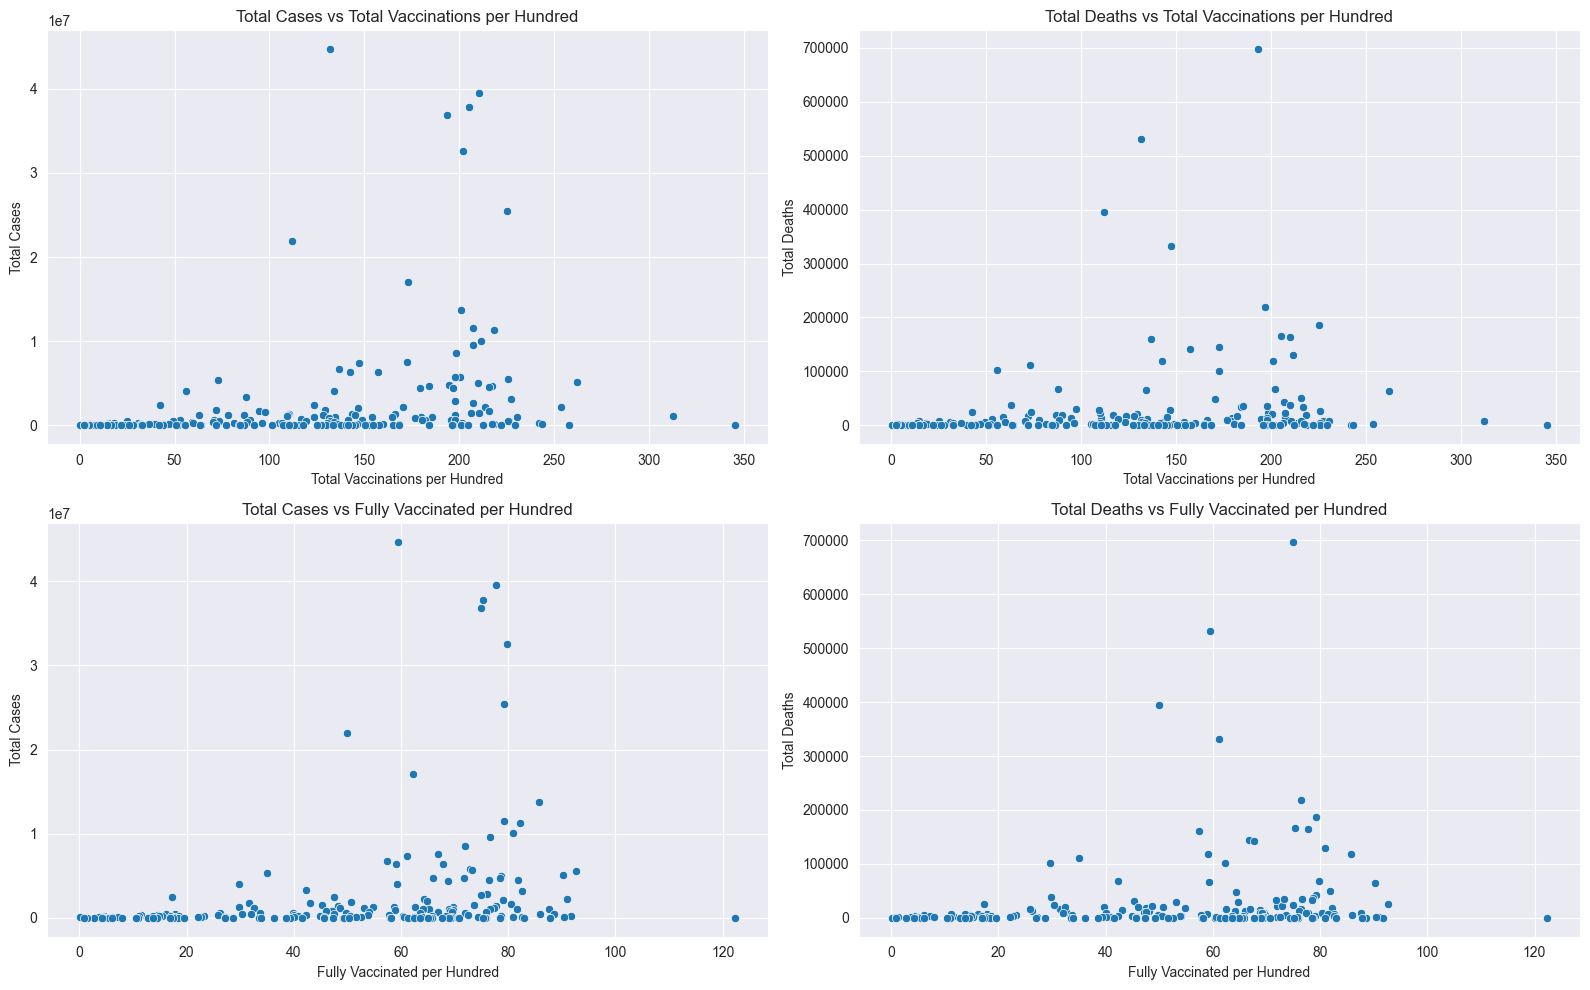

In [5]:
# Scatter plots to visualize the relationship between vaccination metrics and cases/deaths
plt.figure(figsize=(16, 10))

# Total Cases vs Vaccination per hundred
plt.subplot(2, 2, 1)
sns.scatterplot(data=merged_data, x='total_vaccinations_per_hundred', y='Total Cases')
plt.title('Total Cases vs Total Vaccinations per Hundred')
plt.xlabel('Total Vaccinations per Hundred')
plt.ylabel('Total Cases')

# Total Deaths vs Vaccination per hundred
plt.subplot(2, 2, 2)
sns.scatterplot(data=merged_data, x='total_vaccinations_per_hundred', y='Total Deaths')
plt.title('Total Deaths vs Total Vaccinations per Hundred')
plt.xlabel('Total Vaccinations per Hundred')
plt.ylabel('Total Deaths')

# Fully vaccinated per hundred vs Total Cases
plt.subplot(2, 2, 3)
sns.scatterplot(data=merged_data, x='people_fully_vaccinated_per_hundred', y='Total Cases')
plt.title('Total Cases vs Fully Vaccinated per Hundred')
plt.xlabel('Fully Vaccinated per Hundred')
plt.ylabel('Total Cases')

# Fully vaccinated per hundred vs Total Deaths
plt.subplot(2, 2, 4)
sns.scatterplot(data=merged_data, x='people_fully_vaccinated_per_hundred', y='Total Deaths')
plt.title('Total Deaths vs Fully Vaccinated per Hundred')
plt.xlabel('Fully Vaccinated per Hundred')
plt.ylabel('Total Deaths')

plt.tight_layout()
plt.show()


Na wykresach można zauważyć, że:

Kraje z wyższą liczbą szczepień na 100 osób (lub w pełni zaszczepionych) mają tendencję do raportowania większej liczby przypadków i zgonów. Może to wynikać z:

Lepszej diagnostyki i raportowania w krajach z wyższym poziomem szczepień.
Możliwości, że szczepienia zwiększyły się po wybuchu pandemii w krajach o większej liczbie przypadków.
Nie ma wyraźnej negatywnej korelacji między szczepieniami a przypadkami lub zgonami, co oznacza, że sama liczba szczepień nie zawsze oznacza mniejszą liczbę przypadków/zgonów na poziomie kraju.

Warto zauważyć, że wykresy pokazują pewne odchylenia i kraje o wyjątkowo wysokich liczbach przypadków, które mogą zaburzać analizę.

In [11]:
# Budujemy model regresji, aby sprawdzić, które wskaźniki mają największy wpływ na liczby przypadków i zgonów.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for regression model
features = ['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
            'people_fully_vaccinated_per_hundred', '2022 Population']
target_cases = 'Total Cases'
target_deaths = 'Total Deaths'

# Drop missing values and separate features and target
cleaned_data = merged_data.dropna(subset=features + [target_cases, target_deaths])
X = cleaned_data[features]
y_cases = cleaned_data[target_cases]
y_deaths = cleaned_data[target_deaths]

# Split the data into training and testing sets
X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(X, y_cases, test_size=0.2, random_state=42)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(X, y_deaths, test_size=0.2, random_state=42)

# Train regression models
model_cases = LinearRegression()
model_deaths = LinearRegression()

model_cases.fit(X_train_cases, y_train_cases)
model_deaths.fit(X_train_deaths, y_train_deaths)

# Predict and evaluate
y_pred_cases = model_cases.predict(X_test_cases)
y_pred_deaths = model_deaths.predict(X_test_deaths)

mse_cases = mean_squared_error(y_test_cases, y_pred_cases)
mse_deaths = mean_squared_error(y_test_deaths, y_pred_deaths)

r2_cases = r2_score(y_test_cases, y_pred_cases)
r2_deaths = r2_score(y_test_deaths, y_pred_deaths)

mse_cases, r2_cases, mse_deaths, r2_deaths

(14234820670744.7,
 0.34047258883318277,
 3355183313.4570947,
 0.23639204060500063)

Przypadki COVID-19:
MSE (Błąd średniokwadratowy): 14,234,820,670,019.65
R² (Współczynnik determinacji): 0.34
Zgony:
MSE (Błąd średniokwadratowy): 3,355,183,313.26
R² (Współczynnik determinacji): 0.24
Interpretacja:
Model regresji dla przypadków COVID-19 tłumaczy około 34% wariancji w danych, co sugeruje umiarkowaną skuteczność w przewidywaniu liczby przypadków na podstawie wskaźników szczepień i populacji.
Dla zgonów wynik R² wynosi 24%, co oznacza słabszą zdolność modelu do przewidywania na podstawie wybranych cech.

In [14]:
# Drzewo decyzyjne
from sklearn.ensemble import RandomForestRegressor

# Use Random Forest for a more advanced regression model
rf_model_cases = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_deaths = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Random Forest models
rf_model_cases.fit(X_train_cases, y_train_cases)
rf_model_deaths.fit(X_train_deaths, y_train_deaths)

# Predict using Random Forest
y_rf_pred_cases = rf_model_cases.predict(X_test_cases)
y_rf_pred_deaths = rf_model_deaths.predict(X_test_deaths)

# Evaluate Random Forest models
mse_rf_cases = mean_squared_error(y_test_cases, y_rf_pred_cases)
mse_rf_deaths = mean_squared_error(y_test_deaths, y_rf_pred_deaths)

r2_rf_cases = r2_score(y_test_cases, y_rf_pred_cases)
r2_rf_deaths = r2_score(y_test_deaths, y_rf_pred_deaths)

mse_rf_cases, r2_rf_cases, mse_rf_deaths, r2_rf_deaths

(35217023096909.984,
 -0.6316743715530031,
 6761554417.184939,
 -0.538865775272598)

Model Random Forest, w tej konfiguracji, osiągnął gorsze wyniki niż regresja liniowa:

Wyniki Random Forest:
Przypadki COVID-19:
MSE: 35,217,023,096,909.98
R²: -0.63 (model nie jest lepszy od średniej, co oznacza, że przewidywania są bardzo niedokładne).
Zgony:
MSE: 6,761,554,417.18
R²: -0.54 (model nie tłumaczy danych, a jego wyniki są znacznie gorsze od prostych założeń średniej).

In [15]:
population_data['population_density'] = population_data['2022 Population'] / population_data['Area (km²)']



In [16]:
merged_data = merged_data.merge(population_data[['Country/Territory', 'population_density']],
                                left_on='Country',
                                right_on='Country/Territory',
                                how='left')

# Drop redundant column
merged_data = merged_data.drop(columns=['Country/Territory'])

# Update features to include population_density
features.append('population_density')

# Display the updated dataset structure
merged_data.head()

,Serial Number,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Test,Population,2022 Population,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,population_density
0,2,India,44682784,530740.0,44150289.0,1755.0,915265788.0,1.406632e+09,1417173173,1.834501e+09,984838143.0,828229455.0,1.765216e+09,1.829085e+09,131.66,70.68,59.44,2996.970320,431.067491
1,3,France,39524311,164233.0,39264546.0,95532.0,271490188.0,6.558452e+07,64626628,1.416662e+08,53993210.0,52438706.0,1.416656e+08,1.415863e+08,210.12,80.08,77.78,4605.289474,117.141950
2,4,Germany,37779833,165711.0,37398100.0,216022.0,122332384.0,8.388360e+07,83369843,1.719400e+08,63664250.0,63142649.0,1.719157e+08,1.719040e+08,204.93,75.88,75.26,4483.382932,233.454424
3,5,Brazil,36824580,697074.0,35919372.0,208134.0,63776166.0,2.153536e+08,215313498,4.135596e+08,181078067.0,160272858.0,4.097208e+08,4.113785e+08,193.26,84.62,74.90,4409.162844,25.284099
4,6,Japan,32588442,68399.0,21567425.0,10952618.0,92144639.0,1.255848e+08,123951692,2.543456e+08,102467506.0,100633737.0,1.794754e+08,2.517397e+08,201.78,81.29,79.84,4931.180247,327.975265


In [19]:
medium_age_data = pd.read_csv('data/MedianAge.csv')
medium_age_data.head()

# // Merge the median age from 2020 data with the main dataset

merged_data = merged_data.merge(medium_age_data[['Country', '2020']], left_on='Country', right_on='Country', how='left')

In [21]:
merged_data = merged_data.rename(columns={'2020': 'avg_age'})

In [23]:
merged_data.to_csv('data/merged_covid.csv', index=False)

In [1]:
correlation_columns = [
    'Total Cases', 'Total Deaths', 'total_vaccinations',
    'people_vaccinated', 'avg_age', 'population_density'
]

# Compute the correlation matrix
correlation_matrix = merged_data[correlation_columns].corr(type='pearson')

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

NameError: name 'merged_data' is not defined

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract the updated features and targets from the dataset
target_cases = 'Total Cases'
target_deaths = 'Total Deaths'

features_selected = [
    'avg_age',
    'total_vaccinations',
    'people_vaccinated',
]

cleaned_data = merged_data.dropna(subset=features_selected)

# Update X and y without missing values
X = cleaned_data[features_selected]
y_cases = cleaned_data[target_cases]
y_deaths = cleaned_data[target_deaths]

# Split the data into training and testing sets again
X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(X, y_cases, test_size=0.2, random_state=42)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(X, y_deaths, test_size=0.2, random_state=42)

# Train regression models again
model_cases = LinearRegression()
model_deaths = LinearRegression()

model_cases.fit(X_train_cases, y_train_cases)
model_deaths.fit(X_train_deaths, y_train_deaths)

# Predict and evaluate again
y_pred_cases = model_cases.predict(X_test_cases)
y_pred_deaths = model_deaths.predict(X_test_deaths)

mse_cases = mean_squared_error(y_test_cases, y_pred_cases)
r2_cases = r2_score(y_test_cases, y_pred_cases)
mse_deaths = mean_squared_error(y_test_deaths, y_pred_deaths)
r2_deaths = r2_score(y_test_deaths, y_pred_deaths)

mse_cases, r2_cases, mse_deaths, r2_deaths

(6289817716957.891, 0.28126617569101986, 649661538.531635, 0.5234608668629157)

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest models
rf_model_cases = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_deaths = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
rf_model_cases.fit(X_train_cases, y_train_cases)
rf_model_deaths.fit(X_train_deaths, y_train_deaths)

# Predict on the test set
y_rf_pred_cases = rf_model_cases.predict(X_test_cases)
y_rf_pred_deaths = rf_model_deaths.predict(X_test_deaths)

# Evaluate Random Forest models
mse_rf_cases = mean_squared_error(y_test_cases, y_rf_pred_cases)
r2_rf_cases = r2_score(y_test_cases, y_rf_pred_cases)

mse_rf_deaths = mean_squared_error(y_test_deaths, y_rf_pred_deaths)
r2_rf_deaths = r2_score(y_test_deaths, y_rf_pred_deaths)

{
    "Random Forest MSE (Cases)": mse_rf_cases,
    "Random Forest R2 (Cases)": r2_rf_cases,
    "Random Forest MSE (Deaths)": mse_rf_deaths,
    "Random Forest R2 (Deaths)": r2_rf_deaths,
}

{'Random Forest MSE (Cases)': 9043612774434.39,
 'Random Forest R2 (Cases)': -0.033408389151620144,
 'Random Forest MSE (Deaths)': 2272056836.940279,
 'Random Forest R2 (Deaths)': -0.6665970375295402}